### Examples of Complex-Valued Signal Denoising for Baseline Methods:  
### Wavelets (W), Singular Spectrum Analysis (SSA), and Time-Domain Deconvolution (DC) 
Written by Amber Day and Natalie Klein

In [1]:
import pywt
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib import gridspec
from splitml.util import plot_complex_ts
from splitml.data import synthetic_data_gen
from splitml.losses import complex_mse
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
from scipy.optimize import least_squares
from skimage.restoration import denoise_wavelet
import warnings
warnings.simplefilter("ignore")

### Data Generation
***
Generate clean and noisy data sets and save parameters used in signal generation.

See `splitml/data.py` for data generation function

In [2]:
N_signals = 20 # Increase to match paper, but computation is slow
nt = 1024

(clean_training, noisy_training, clean_validation, noisy_validation, 
    clean_testing, noisy_testing, sig_params_training, sig_params_validation, 
    sig_params_testing, t) = synthetic_data_gen(N = N_signals, nt = nt, fs = 1./1.8e-05, 
    w_range = [-50,50], phi_range = [-np.pi, np.pi], T2_range = [1e-3, 1e-2], 
    sigma_range = [1e-3, 1e-2], A_range = [1,2], s = 1)

noisy_training = clean_training + noisy_training
noisy_validation = clean_validation + noisy_validation
noisy_testing = clean_testing + noisy_testing

N_test = noisy_testing.shape[0]

Create plot of generated data.

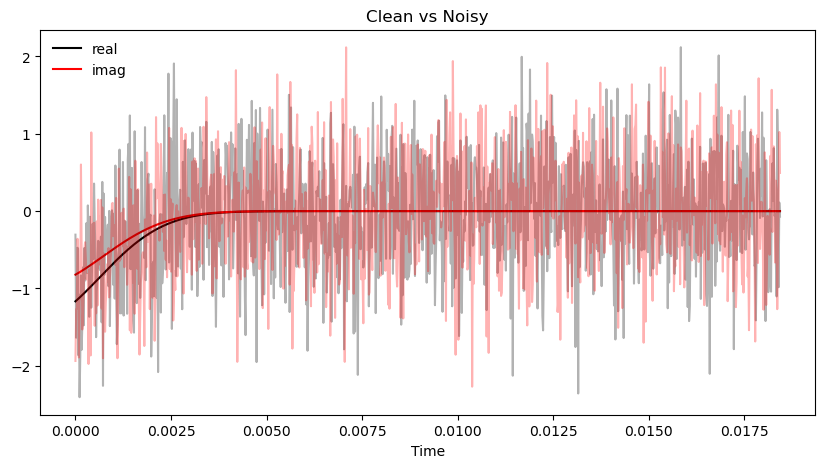

In [3]:
for i in range(1):
    fig = plt.figure() 
    fig.set_size_inches(10,5) 
    plot_complex_ts(t, clean_testing[(i+1),:])
    plt.legend(frameon=False)
    plot_complex_ts(t, noisy_testing[(i+1),:], alpha=0.3)
    plt.xlabel('Time')
    plt.title('Clean vs Noisy')
    plt.show()

### Baseline Fit
***
Denoising testing data with Wavelets (W), Singular Spectrum Analysis (SSA), and Time-Domain Deconvolution (DC)

Funciton for mse

In [4]:
def cmse(input, target):
    resid = input - target
    return np.mean(resid * np.conj(resid)).real

Wavelet Fit

In [5]:
np.random.seed(42)
results = {'data': [], 'mse': [], 'mode': []}
mode = 'symmetric' # type of padding
pad = 1024 # amount of padding, note that input for wavelets needs to be a power of two
half_pad = 512
wavelet_real = np.zeros((N_test,nt))

for i in range(len(noisy_testing.real)):
    level = 5
    data = noisy_testing.real[i,:]
    data = pywt.pad(data, pad_widths=half_pad, mode=mode) # add padding
    wavelet = denoise_wavelet(data, method='BayesShrink', mode='soft', wavelet_levels=12, wavelet='sym4', rescale_sigma='True')
    wavelet_real[i,:] = wavelet[half_pad:(half_pad+pad)] # remove padding

wavelet_imag = np.zeros((N_test,nt))
for i in range(len(noisy_testing.imag)):
    level = 5
    data = noisy_testing.imag[i,:]
    data = pywt.pad(data, pad_widths=half_pad, mode=mode) # add padding
    wavelet = denoise_wavelet(data, method='BayesShrink', mode='soft', wavelet_levels=12, wavelet='sym4', rescale_sigma='True')
    wavelet_imag[i,:] = wavelet[half_pad:(half_pad+pad)] # remove padding

wavelet_complex = wavelet_real + wavelet_imag*1j
for i in range(len(wavelet_complex)):
    wavelet_mse = cmse(wavelet_complex/(np.array(sig_params_testing['A']))[i], clean_testing/(np.array(sig_params_testing['A']))[i])
wavelet_mse = np.mean(wavelet_mse)

SSA Fit

In [7]:
def psuedoinv_H(Z):
    m,n = Z.shape
    ad = [] 
    for i in range(m-1):
        ad.append( np.mean( np.fliplr( Z[:i+1,:i+1] ).diagonal()))
    ad = np.array(ad)

    ad2 = []
    for i in range(n):
        ad2.append( np.mean( np.fliplr( Z[(m-1-i):,(n-1-i):] ).diagonal()))
    ad2 = np.flip(ad2)
    
    z = np.append( ad, ad2 ) 
    return z

def get_w(m,n):
    Z = np.ones((m,n))
    ad = [] 
    for i in range(m-1):
        ad.append( np.sum( np.fliplr( Z[:i+1,:i+1] ).diagonal()))
    ad = np.array(ad)

    ad2 = []
    for i in range(n):
        ad2.append( np.sum( np.fliplr( Z[(m-1-i):,(n-1-i):] ).diagonal()))
    ad2 = np.flip(ad2)
    
    w = np.append( ad, ad2 ) 

    return np.array(w)

def grad_cadzow(fid, iters=15, rank=5, alpha=1):
    ''' Gradient Cadzow (iterative) Wang et al 2020
    '''
    z = np.copy(fid)
    y = np.copy(fid)
    l = round(len(fid)/2)
    # weights
    Z = scipy.linalg.hankel(z[:l+1],z[l:])
    m,n = Z.shape
    D = get_w(m,n)

    for k in range(iters):

        # take gradient step and hankelize
        z_tilde = z + 1/D * alpha * (y-z)
        Z = scipy.linalg.hankel(z_tilde[:l+1],z_tilde[l:])
        m,n = Z.shape
        # low rank projection
        U, s, Vh = np.linalg.svd(Z, full_matrices=False) #s is a vector of singular values, not a matrix, Vt is already transposed
        Zr = np.dot(U[:, :rank] * s[:rank], Vh[:rank, :])
        # psuedo invert hankel to update z
        z = psuedoinv_H(Zr)

    return z

SSA_complex = np.zeros_like(noisy_testing)
for i in range(len(noisy_testing)):
    sig = grad_cadzow(noisy_testing[i, :], iters=20, rank=1, alpha=1)
    SSA_complex[i, :] = sig
for i in range(len(SSA_complex)):
    SSA_mse = cmse(SSA_complex/(np.array(sig_params_testing['A']))[i], clean_testing/(np.array(sig_params_testing['A']))[i])
SSA_mse = np.mean(SSA_mse)

DC Fit

In [8]:
def resid_fun(params, t, y):
    # A, sigma, T2, w, phi, C = parameters
    A, sigma, T2, w, phi = params
    sig = A * np.exp(-0.5*(t/sigma)**2) * np.exp(-t/T2) * np.exp(1j*(2*np.pi*w*t + phi)) # + C
    resid = y - sig
    return np.concatenate([np.real(resid), np.imag(resid)])
def get_xtrue(df, i):
    x0 = np.zeros(5)
    x0[0] = np.mean(df[i, 3]) # A
    x0[1] = np.mean(df[i, 4]) # sigma
    x0[2] = np.mean(df[i, 2]) # T2
    x0[3] = np.mean(df[i, 0]) # w
    x0[4] = np.mean(df[i, 1]) # phi
    return x0

# Initialization for DC chosen based on known parameters for dataset
x_scale = np.zeros(5)
x_scale[0] = np.std(np.array(sig_params_testing['A'])) # A
x_scale[1] = np.std(np.array(sig_params_testing['sigma'])) # sigma
x_scale[2] = np.std(np.array(sig_params_testing['T2'])) # T2
x_scale[3] = np.std(np.array(sig_params_testing['w'])) # w
x_scale[4] = np.std(np.array(sig_params_testing['phi'])) # phi

DC_mse = []
DC_complex = [] 
DC_fft_sig = []
for i in range(N_test):
    # DC predictions
    x0 = get_xtrue(np.array(sig_params_testing), i)
    x0 += 0.1 * x_scale * np.random.normal(5)
    data_scl = 1
    res = least_squares(resid_fun, x0, args=(t[:1024], noisy_testing[i, :]/data_scl), method='lm', x_scale=x_scale)
    A, sigma, T2, w, phi = list(res.x)
    sig = A * np.exp(-0.5*(t[:1024]/sigma)**2) * np.exp(-t[:1024]/T2) * np.exp(1j*(2*np.pi*w*t[:1024] + phi))
    sig *= data_scl
    m = cmse(sig/(np.array(sig_params_testing['A']))[i], clean_testing[i, :]/(np.array(sig_params_testing['A']))[i])
    DC_mse.append(m) # rescaled MSE
    DC_complex.append(sig)
    DC_fft = np.fft.fftshift(np.abs(fft(sig))) #fourier transform
    DC_fft_sig.append(DC_fft)

DC_mse = np.mean(DC_mse)
DC_complex = np.array(DC_complex)
DC_fit_real = DC_complex.real
DC_fit_imag = DC_complex.imag
DC_fft_sig = np.array(DC_fft_sig)

### Baseline Plot
***
Prepare data for frequency domain plot

In [9]:
device = torch.device('cpu') # set device
# Preparing Testing Data
noisy_testing_data = torch.tensor(noisy_testing).to(device).type(torch.complex64)
clean_testing_data = torch.tensor(clean_testing).to(device).type(torch.complex64)
noisy_testing_cat = torch.cat((noisy_testing_data.real, noisy_testing_data.imag),0)
# Fast Fourier Transform of Testing Data
freq = fftfreq(n=len(t), d=1.8e-05)
freq = np.fft.fftshift(freq)
fft_noisy = np.fft.fftshift(np.abs(fft(noisy_testing)))
fft_clean = np.fft.fftshift(np.abs(fft(clean_testing)))
wavelet_fft = np.fft.fftshift(np.abs(fft(wavelet_complex)))# Fast Fourier Transform
SSA_fft = np.fft.fftshift(np.abs(fft(SSA_complex)))# Fast Fourier Transform
DC_fft = np.fft.fftshift(np.abs(fft(DC_complex)))# Fast Fourier Transform


Plot of Results in the Time Domain and Frequency Domain

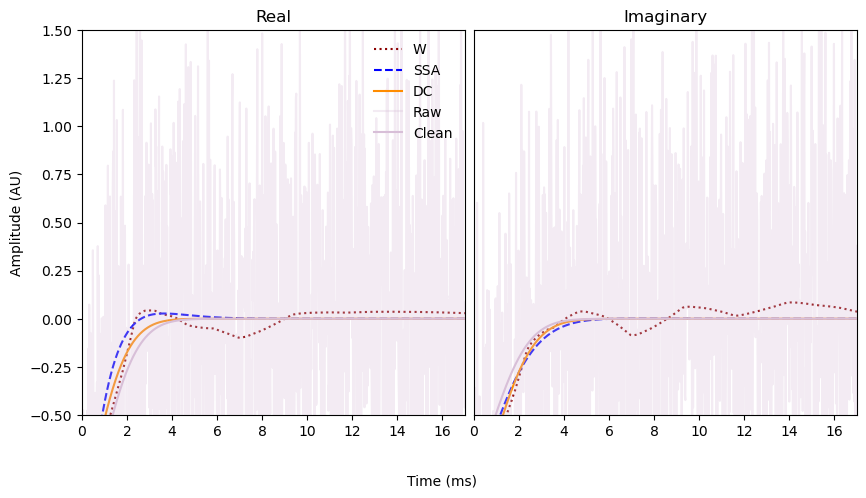

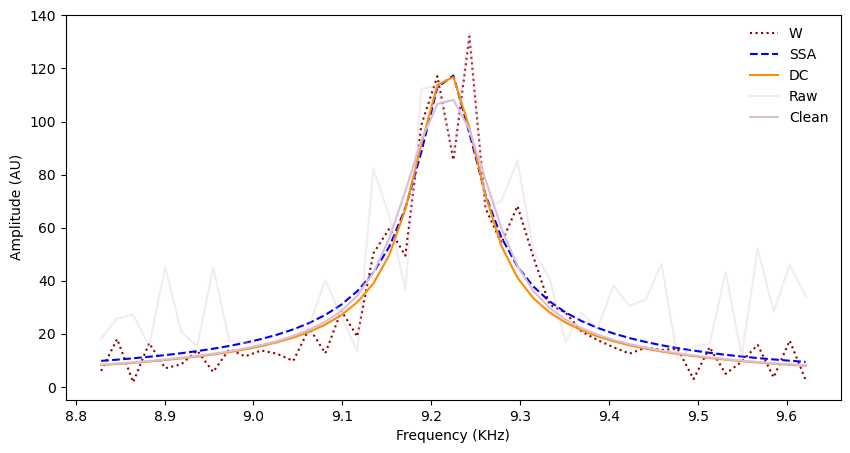

In [10]:
row=1
### Time Domain Plot ###
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.023) 
fig.set_size_inches(10,5)
fig.text(0.45, -.03, 'Time (ms)')

# Real component plot
ax1 = plt.subplot(gs[0,0])
plt.plot((t*1000), wavelet_real[row,:], label='W',color = 'darkred', linestyle='dotted')
plt.plot((t*1000), SSA_complex.real[row,:], label='SSA',color = 'b', linestyle='dashed')
plt.plot((t*1000), DC_fit_real[row,:], label='DC',color = 'darkorange')
plt.plot((t*1000), noisy_testing.real[row,:], alpha=0.3, label='Raw',color = 'thistle')
plt.plot((t*1000), clean_testing.real[row,:], label='Clean',color = 'thistle')
plt.ylabel('Amplitude (AU)')
plt.ylim(-.5,1.5)
plt.xlim(0,17)
plt.title('Real')
plt.legend(loc='upper right', frameon=False)

# Imaginary component plot
ax2 = plt.subplot(gs[0,1])
plt.plot((t*1000), wavelet_imag[row,:], label='W',color = 'darkred', linestyle='dotted')
plt.plot((t*1000), SSA_complex.imag[row,:], label='SSA',color = 'b', linestyle='dashed')
plt.plot((t*1000), DC_fit_imag[row,:], label='DC',color = 'darkorange')
plt.plot((t*1000), noisy_testing.imag[row,:], alpha=0.3, label='Raw',color = 'thistle')
plt.plot((t*1000), clean_testing.imag[row,:], label='Clean',color = 'thistle')
plt.yticks([])
plt.ylim(-.5,1.5)
plt.xlim(0,17)
plt.title('Imaginary')
plt.show()


### Frequency Domain Plot ###
fig = plt.figure()
fig.set_size_inches(10,5)
zoom = [490, 535]
plt.plot((t[zoom[0]:zoom[1]]*1000), wavelet_fft[row,zoom[0]:zoom[1]], label='W',color = 'darkred', linestyle='dotted')
plt.plot((t[zoom[0]:zoom[1]]*1000), SSA_fft[row,zoom[0]:zoom[1]], label='SSA',color = 'b', linestyle='dashed')
plt.plot((t[zoom[0]:zoom[1]]*1000), DC_fft[row,zoom[0]:zoom[1]], label='DC',color = 'darkorange')
plt.plot((t[zoom[0]:zoom[1]]*1000), fft_noisy[row,zoom[0]:zoom[1]], alpha=0.3, label='Raw',color = 'thistle')
plt.plot((t[zoom[0]:zoom[1]]*1000), fft_clean[row,zoom[0]:zoom[1]], label='Clean',color = 'thistle')
plt.xlabel('Frequency (KHz)')
plt.ylabel('Amplitude (AU)')
plt.legend(frameon=False)
plt.show()
        

### Baseline $R^2$
***
Calculate MSE for comparison to no signal prediction for test set

In [11]:
# Create zero Vector
device = torch.device('cpu') # set device
z = np.zeros((N_test, nt),dtype=complex)
z = torch.tensor(z).to(device).type(torch.complex64)
A = np.array(sig_params_testing['A'])
clean_testing_data = torch.tensor(clean_testing).to(device).type(torch.complex64)
# Rescale clean signal
for i in range(len(clean_testing_data)):
    clean_testing_data[i,:] = clean_testing_data[i,:]/A[i]
no_sig_mse = complex_mse(z, clean_testing_data).detach().numpy() # rescaled MSE for no signal prediction

Calculate $R^2$

Note: The baselines perform well in this higher SNR scenario

In [12]:
wavelet_rsq = (1-wavelet_mse/no_sig_mse)
print('R sqared for wavelets is', wavelet_rsq)
SSA_rsq = (1-SSA_mse/no_sig_mse)
print('R sqared for SSA is', SSA_rsq)
DC_rsq = (1-DC_mse/no_sig_mse)
print('R sqared for DC is', DC_rsq)

R sqared for wavelets is 0.7791020424039552
R sqared for SSA is 0.7371805277033122
R sqared for DC is 0.9717430254824143
